# Ice Floe Segmentation and Tracking Algorithm

This notebook demonstrates the combined workflow of identifying ice floes in satellite images and identifying potential pairs across images. A more in depth tutorial on the segmentation process itself can be found at https://wilhelmuslab.github.io/IceFloeTracker.jl/tutorials/lopez-acosta-2019-workflow/  

This tutorial is split into two main sections, the first of which is the segmentation algorithm which takes the satellite photos, identifies the ice floes, and produces binary images with identified floes. These binary images are then loaded into the second section of the tutorial which tracks the movement of the ice floes from image to image, and producing vario us representations of the tracked floes' movement over time.

### Environment Setup

We first activate a new environment, `ift_env`. You can replace the environment with whatever name you like. We then add the packages needed for the tutorial. The first time you run this, it may take a few minutes.

In [ ]:
using Pkg
Pkg.activate("ift_env")
Pkg.add(;name="IceFloeTracker", rev="859/merge")
Pkg.add(["Images", "Plots", "DataFrames"])

  Activating project at `~/Documents/research/packages/IceFloeTracker.jl/docs/src/tutorials/segmentationtrackingcombined`
    Updating git-repo `https://github.com/WilhelmusLab/IceFloeTracker.jl.git`
    Updating registry at `~/.julia/registries/HolyLabRegistry`
    Updating git-repo `https://github.com/HolyLab/HolyLabRegistry.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed xkbcommon_jll ────── v1.13.0+0
   Installed GR_jll ───────────── v0.73.19+1
   Installed ImageMagick_jll ──── v7.1.2011+0
   Installed FilePaths ────────── v0.9.0
   Installed QOI ──────────────── v1.0.2
   Installed NearestNeighbors ─── v0.4.24
   Installed OpenSSL ──────────── v1.6.1
   Installed libpng_jll ───────── v1.6.51+0
   Installed StatsAPI ─────────── v1.8.0
   Installed PrettyTables ─────── v3.1.2
   Installed Plots ────────────── v1.41.2
   Installed CairoMakie ───────── v0.15.7
   Installed TableShowUtils ───── v0.2.7
   Installed Glib_jll 

In [48]:
using IceFloeTracker
using Images
using Images: segment_mean, labels_map, SegmentedImage, RGB
using IceFloeTracker.Tracking: FloeTracker, FilterFunction, MinimumWeightMatchingFunction
using Plots
using DataFrames

# Identify Sea Ice Floes

We'll access a pair of images from the IFT validation dataset. You can get your own images from the NASA Worldview Snapshots utility. We use the MODIS 1-4-3 true color, MODIS 7-2-1 false color, and the OpenStreetMap coast mask. The validation dataset has 100 km by 100 km pairs of images from the Aqua and Terra satellites, randomly sampled from Arctic marginal and seasonal ice zones, and includes manually validated floe outlines and image metadata. 
For this tutorial we select case 6, from Baffin Bay. We will use the default settings for the LopezAcosta2019Tiling segmentation algorithm. After the images have been segmented, we will extract floe features and track them.

In [7]:
dataset = filter(c -> c.case_number == 6, Watkins2026Dataset(; ref="v0.1"));

In [9]:
dataset

Dataset(GitHubLoader("https://github.com/danielmwatkins/ice_floe_validation_dataset/", "v0.1", "/tmp/Watkins2026"), 2×30 DataFrame
 Row │        case_number  region      start_date  center_lon  center_lat  cen ⋯
     │ Int64  Int64        String      Dates.Date  Float64     Float64     Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    10            6  baffin_bay  2022-05-30    -73.3612     75.2608   -7 ⋯
   2 │    11            6  baffin_bay  2022-05-30    -73.3612     75.2608   -7
                                                              24 columns omitted)

Initialize the segmentation algorithm:

In [19]:
segmentation_algorithm = LopezAcosta2019Tiling.Segment();

Use dot notation to broadcast the segmentation algorithm across vectors of images. The `modis_` accessor functions grab images on demand from the dataset. 

In [21]:
segments = segmentation_algorithm.(
                modis_truecolor.(dataset),
                modis_falsecolor.(dataset),
                modis_landmask.(dataset));

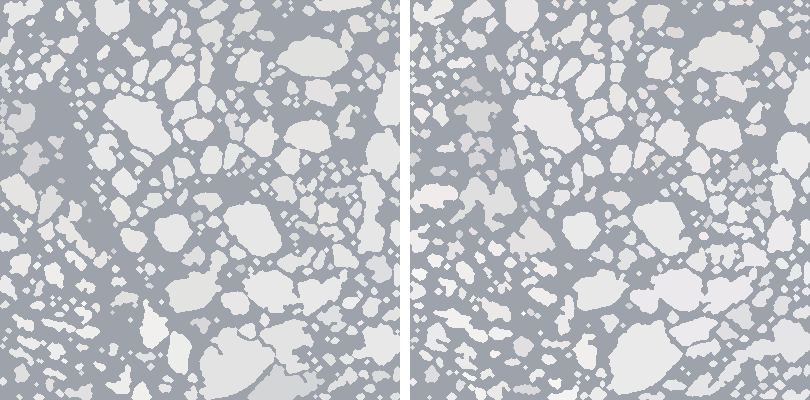

In [ ]:
# Helper function to view a SegmentedImage object
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

mosaicview(view_seg(segments[1]), view_seg(segments[2]), nrow=1, npad=10)

# Tracking Algorithm
The tracking function finds plausible floe matches across rows of DataFrames with feature descriptors. We set up the function in the same way as the segmentation algorithm: we call a function that returns a function. For this tutorial, we'll use two default functions for the algorithm: one function that makes geometric comparisons to reduce the number of candidate matches, and a second function that selects a unique matching between the images. The only additional information we need is an observation time associated with each segmented image. For the IFT validation dataset, this is available in the dataset metadata, which we access with `info()`.

In [50]:
# 
passtimes = info(dataset)[:, "pass_time"]

2-element Vector{Dates.DateTime}:
 2022-05-30T16:44:44
 2022-05-30T15:28:46

We see that the satellite pass times (the time the satellite passed overhead and captured the image) are in reverse chronological order in the dataset, so we need to sort the images first.

In [55]:
segments = reverse(segments)
passtimes = reverse(passtimes)

2-element Vector{Dates.DateTime}:
 2022-05-30T15:28:46
 2022-05-30T16:44:44

Now we initialize and run the FloeTracker:

In [ ]:
# Filtering through potential candidates and matches for tracked floes
tracker = FloeTracker(filter_function=FilterFunction(),
                      matching_function=MinimumWeightMatchingFunction())
tracked = tracker(segments, passtimes);

FloeTracker(ChainedFilterFunction(IceFloeTracker.Tracking.AbstractFloeFilterFunction[DistanceThresholdFilter(:Δt, :Δx, :scaled_distance, LinearTimeDistanceFunction(0.75, 250), :time_distance_test, IceFloeTracker.Tracking.var"#19#21"()), RelativeErrorThresholdFilter(:area, :area, :relative_error_test, PiecewiseLinearThresholdFunction(100, 700, 0.43, 0.17)), RelativeErrorThresholdFilter(:convex_area, :area, :relative_error_test, PiecewiseLinearThresholdFunction(100, 700, 0.44, 0.25)), RelativeErrorThresholdFilter(:major_axis_length, :area, :relative_error_test, PiecewiseLinearThresholdFunction(100, 700, 0.27, 0.13)), RelativeErrorThresholdFilter(:minor_axis_length, :area, :relative_error_test, PiecewiseLinearThresholdFunction(100, 700, 0.28, 0.1)), ShapeDifferenceThresholdFilter(:area, :area, :shape_difference_test, PiecewiseLinearThresholdFunction(100, 700, 0.47, 0.31)), PsiSCorrelationThresholdFilter(:area, :psi_s_correlation_test, PiecewiseLinearThresholdFunction(100, 700, 0.86, 0.96)

# Visualizing the results

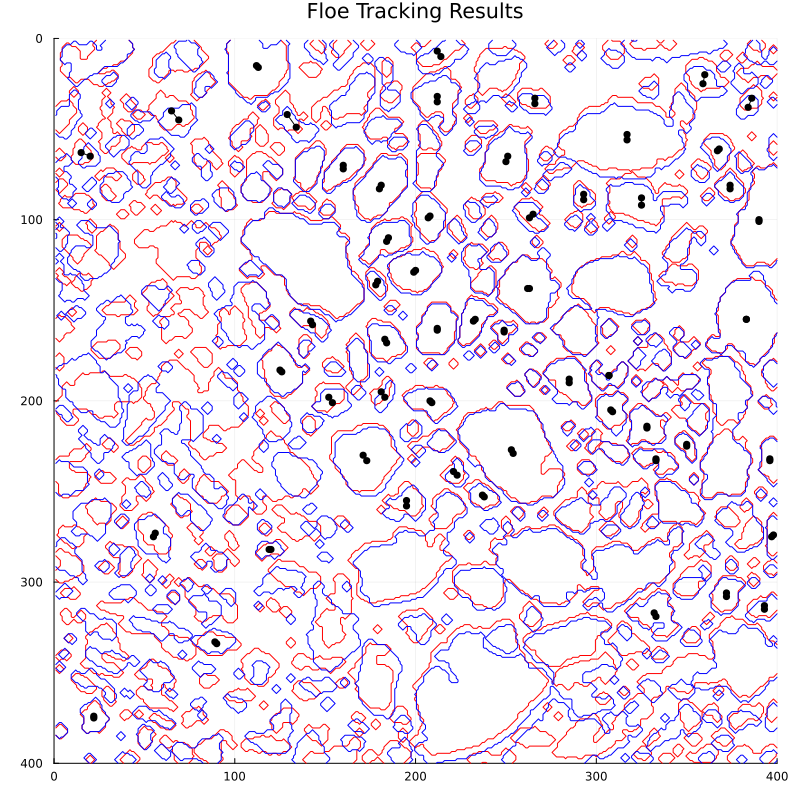

In [73]:
# You can check the metadata via info(dataset) to see what order the images are in
terra, aqua = modis_truecolor.(dataset)

# Binarize segmented image for easy visualization via fontour
aqua_segments = labels_map(segments[1]) .> 0
terra_segments = labels_map(segments[2]) .> 0

plt = contour(title = "Floe Tracking Results", aqua_segments, levels=1, color=:red, label="Aqua", legend=false, 
      aspect_ratio=:equal, size=(800,800))
contour!(terra_segments, levels=1, color=:blue, label="Terra")

# Plot a line segment for each labeled trajectory 
for group in groupby(tracked, :ID)
    x = group.col_centroid
    y = group.row_centroid
    plot!(plt, x, y, color = :black, marker = :circle)
end

# Reverse y-axis to match convention for image display
yflip!(true)

# Truncate plot to image dimensions
ylims!(0, 400)
xlims!(0, 400)
plt

# Next steps
The FloeTracker identifies shapes that persist across images. Because the tracking is based on the shape properties, including the boundary curvature, area, and difference in shapes, if a shape is poorly segmented the tracking will fail. This is apparent for the large floe in the bottom center of the image: it is divided into multiple floes in the Aqua image (blue), and appears as a single floe in Terra (red). We recommend an iterative approach, in which tracked floes are used to find an initial set of tracked floes, then these vectors are used to find estimates of motion for other objects. 

Another note for the above image is that the default minimum floe size is 100 pixels, so smaller floes are intentionally not tracked. Geometric property uncertainty is larger with small objects. 